In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

import os
import random

from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets, transforms
from utils import *
import albumentations as album
#import extractors
import segmentation_models_pytorch as smp
from tqdm.auto import tqdm as tq

sns.set(style='white', context='notebook', palette='deep')

In [2]:
# Need to be run only one time
ENCODER = 'resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 25
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d','softmax' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.PSPNet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=25, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [5]:
model

PSPNet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample):

In [6]:
# helper function for data visualization
def visualize(**images):#plot images in a row
    n_images = len(images)
    plt.figure(figsize=(12,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label 23kjerbfds
def one_hot_encode(image,n_classes):
    x = F.one_hot(image,n_classes)
    return x
 
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

In [7]:
def get_training_augmentation():
    train_transform = [
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
                album.RandomBrightnessContrast(p=0.5),
                album.RandomCrop(width=320, height=320,p=0.5)
                
            ],p=1,
        ),album.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
           
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2,0,1).astype('float32') # convert into tensor

def to_tensor_mask(x,**kwargs):
    return x.astype('float32')


def get_preprocessing(preprocessing_fn=None):
    _transform = [
        album.Lambda(image=preprocessing_fn),
        album.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return album.Compose(_transform)

In [8]:
#transform = transforms.Compose([transforms.ToTensor()])
class BackgroundDataset(torch.utils.data.Dataset):
    def __init__(
            self,path, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.path = path
        self.name = os.listdir(os.path.join(path, 'train_masks'))
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, idx):
        
        # read images and masks
        mask_name = self.name[idx]
        mask_path = os.path.join(self.path,'train_masks',mask_name)
        img_path = os.path.join(self.path,'train_images',mask_name.replace('png','jpg'))

        
#         image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
#         mask = cv2.cvtColor(cv2.imread(mask_path),0)
        image = Image.open(img_path)
        image = image.resize((320,320),Image.ANTIALIAS)
        mask = Image.open(mask_path)
        mask = mask.resize((320,320),Image.ANTIALIAS)
#         image = keep_image_size_open(img_path)
#         mask = keep_mask_size_open(mask_path)
        
        image = np.asarray(image).astype('int32')
        mask = np.asarray(mask).astype('int32')
        mask = np.where(mask<=24,mask,0) # removing every above classes
        
        
   
    
        #one-hot-encode the mask  
        mask = torch.from_numpy(mask).to(torch.int64)
        mask = one_hot_encode(mask,25)
        mask = np.asarray(mask).astype('int32')
        
        
#          #Augmentation
#         sample = self.augmentation(image=image, mask=mask)
#         image, mask = sample['image'], sample['mask']
        

        
         # preprocessing applied only on numpy array image
        sample = self.preprocessing(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
        
            
        return image,mask
        
    def __len__(self):
        return len(self.name)

In [9]:
if __name__ == '__main__':
    data = BackgroundDataset('',augmentation = get_training_augmentation(),preprocessing=get_preprocessing(preprocessing_fn))
    check_image = data[219][0] # checking for the random 100th image
    check_mask = data[219][1]
    print(check_image.shape,check_mask.shape)
    print(check_image.dtype,check_mask.dtype)
    print(len(data))

(3, 320, 320) (25, 320, 320)
float32 float32
261


In [10]:
# visualize(original_image=check_image,
#           original_mask=reverse_one_hot(check_mask)
#          )

In [11]:
# p  = os.path.join('train_images',os.listdir('train_images')[11])
# ip = Image.open(p)
# ipa = np.asarray(ip)
# ic = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
# tp=np.transpose(ic,(2,1,0))
# tp.shape
# tt = torch.from_numpy(ipa).transpose(2,0)
# tt.shape


In [12]:
bs = 3
nw = 0
# Splitting into Train and Val
full_dataset = BackgroundDataset('',preprocessing=get_preprocessing(preprocessing_fn))
train_size = int(0.9 * len(full_dataset))
val_size   = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Creating  data_loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs,num_workers=nw,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=bs,num_workers=nw,shuffle=True)


In [13]:
it, lt = next(iter(train_loader))
print(it.shape,lt.shape)
print(it.dtype,lt.dtype)
print(len(train_loader)*bs,len(val_loader)*bs)

torch.Size([3, 3, 320, 320]) torch.Size([3, 25, 320, 320])
torch.float32 torch.float32
234 27


In [109]:
def mIOU(label, pred, num_classes=19):
    #pred = F.softmax(pred, dim=1)              
#     pred = torch.argmax(pred, dim=1).squeeze(1)
    iou_list = list()
    present_iou_list = list()

    pred = pred.view(-1)
    label = label.view(-1)
    # Note: Following for loop goes from 0 to (num_classes-1)
    # and ignore_index is num_classes, thus ignore_index is
    # not considered in computation of IoU.
    for sem_class in range(num_classes):
        pred_inds = (pred == sem_class)
        target_inds = (label == sem_class)
        if target_inds.long().sum().item() == 0:
            iou_now = float('nan')
        else: 
            intersection_now = (pred_inds[target_inds]).long().sum().item()
            union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)
        iou_list.append(iou_now)
    return np.mean(present_iou_list)

In [110]:
def dice_no_threshold(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None,
):
 
    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets) + torch.sum(outputs)
    dice = 2 * intersection / (union + eps)

    return dice


In [122]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# define loss function
criterion = smp.losses.DiceLoss(mode='multiclass',classes=27)

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]
define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0005),
])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)

In [126]:
np.arange(27)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [124]:
# number of epochs to train the model
n_epochs = 20
train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
valid_loss_min = np.Inf # track change in validation loss
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    bar = tq(train_loader, postfix={"train_loss":0.0})
    for data, target in bar:
        print()
        optimizer.zero_grad()
    
        output = model(data) # made prediction in float that's why target converted to float
        print(output.shape,output.dtype)

        # calculate the batch loss
        loss   = criterion(output, target.to(torch.int64))
        #print(loss)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        bar.set_postfix(ordered_dict={"train_loss":loss.item()})
    ######################    
    # validate the model #
    ######################
    model.eval()
    del data, target
    with torch.no_grad():
        bar = tq(val_loader, postfix={"val_loss":0.0, "dice_score":0.0})
        for data, target in bar:
        
            output = model(data)
            print(output.dtype)
            #output = target.to(torch.float)
            # calculate the batch loss
            loss = criterion(output, target.to(torch.int64))
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            dice_cof = dice_no_threshold(output.cpu(), target.cpu(),threshold=0.5).item()
            dice_score +=  dice_cof * data.size(0)
            bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(val_loader.dataset)
    dice_score = dice_score/len(val_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    dice_score_list.append(dice_score)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {:.6f}'.format(
        epoch, train_loss, valid_loss, dice_score))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'PSP_MODEL_final.pt')
        valid_loss_min = valid_loss
    
    scheduler.step(valid_loss)

  0%|          | 0/78 [00:00<?, ?it/s, train_loss=0]


torch.Size([3, 27, 320, 320]) torch.float32

torch.Size([3, 27, 320, 320]) torch.float32


KeyError: dtype('int64')

In [20]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 20

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0005),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
# if os.path.exists('../input/pyramid-scene-parsing-pspnet-resnext50-pytorch/best_model.pth'):
#     model = torch.load('../input/pyramid-scene-parsing-pspnet-resnext50-pytorch/best_model.pth', map_location=DEVICE)

In [21]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [22]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(val_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model.state_dict(), 'PSPNET_model.pt')
            print('Model saved!')


Epoch: 0
valid: 100%|█████████████████████████████████████| 9/9 [00:47<00:00,  5.33s/it, dice_loss - 0.4423, iou_score - 0.3992]
Model saved!

Epoch: 1
train:  49%|█████████████████                  | 38/78 [05:09<05:26,  8.16s/it, dice_loss - 0.3625, iou_score - 0.4765]


KeyboardInterrupt: 

In [6]:
def to_tensor(x, **kwargs):
    return x.transpose(2,0,1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    _transform = [
        album.Lambda(image=preprocessing_fn),
        album.Lambda(image=to_tensor),
    ]
    return album.Compose(_transform)

def get_validation_augmentation():
    test_transform = [
        album.PadIfNeeded(min_height=640, min_width=640, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)

In [7]:
#transform = transforms.Compose([transforms.ToTensor()])
class TestDataset(torch.utils.data.Dataset):

    def __init__(
            self,path, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.path = path
        self.name = os.listdir(os.path.join(path,'test_images'))
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, idx):
        
        # read images and masks
        mask_name = self.name[idx]
        img_path = os.path.join(self.path,'test_images',mask_name)

        image = keep_image_size_open(img_path)
        
        image = np.asarray(image).astype('int64')
        
      # preprocessing applied only on numpy array image
        sample = self.augmentation(image=image)
        image = sample['image']
        sample = self.preprocessing(image=image)
        image = sample['image']
        
            
        return image
        
    def __len__(self):
        # return length of 
        return len(self.name)

In [8]:
if __name__ == '__main__':
    data = TestDataset('',augmentation=get_validation_augmentation(),preprocessing=get_preprocessing(preprocessing_fn))
    check_image = data[100] # checking for the random 100th image
    print(check_image.shape)
    print(check_image.dtype)
    print(len(data))

NameError: name 'keep_image_size_open' is not defined

In [55]:
test_loader = torch.utils.data.DataLoader(data, batch_size=8,shuffle=True)

In [56]:
len(test_loader)

14

In [18]:
# if os.path.exists('best_model_pspnet.pt'):
#     device = torch.device('cpu')
#     model.load_state_dict(torch.load('best_model_pspnet.pt', map_location=device))
#     model.eval();

In [59]:
from tqdm.auto import tqdm as tq

In [60]:
from tqdm.auto import tqdm as tq
test_mask=[]
for data in tqfrom tqdm.auto import tqdm as tq(test_loader):
    output = model(data).cpu().detach().numpy()
    print(output.shape)
    for b in range(output.shape[0]):
                   test_mask.append(output[b])


  0%|          | 0/14 [00:00<?, ?it/s]

(8, 27, 640, 640)
(8, 27, 640, 640)
(8, 27, 640, 640)
(8, 27, 640, 640)
(8, 27, 640, 640)
(8, 27, 640, 640)
(8, 27, 640, 640)
(8, 27, 640, 640)
(8, 27, 640, 640)
(8, 27, 640, 640)
(8, 27, 640, 640)
(8, 27, 640, 640)
(8, 27, 640, 640)
(8, 27, 640, 640)


In [61]:
mask = []
for m in test_mask:
    m1 = np.transpose(m,(1,2,0))
    mask.append(np.argmax(m1,axis=2))

In [62]:
len(mask)

112

In [63]:
np.array(mask).max()

23

In [66]:
test_image_path = os.path.join('test_images',os.listdir('test_images')[10])
ti = Image.open(test_image_path)

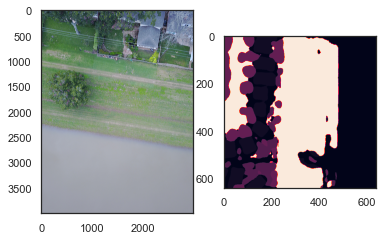

In [67]:
plt.subplot(1,2,1)
plt.imshow(ti)
plt.subplot(1,2,2)
plt.imshow(mask[10])
plt.show()

In [68]:
path = r"C:\Users\rkroc\Desktop\FDL_kaggle\pspnet_test_masks"
file_name = list(os.listdir('test_images'))
for i in range(len(mask)):
    mask_name = file_name[i]
    mask_name = mask_name.replace('jpg','png')
    file_path = os.path.join(path,mask_name)
    img = Image.fromarray(mask[i].astype('uint8'))
    img.save(file_path)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111


In [69]:
import os

from PIL import Image
import numpy as np

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def create_rles():
    """Used for Kaggle submission: predicts and encode all test images"""
    dir = 'test_masks/'
    N = len(list(os.listdir(dir)))
    with open('submission_file_pspnet.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in enumerate(os.listdir(dir)):
            # print('{}/{}'.format(index, N))

            mask = Image.open(dir+i)
            mask = mask.resize((1024, 1024), resample=Image.NEAREST)
            mask = np.array(mask)

            for x in range(1, 25):
                enc = rle_encode(mask == x)
                f.write(f"{i.split('_')[0]}_{x},{enc}\n")

create_rles()

In [3]:
# Trying whole arhitecture
PATH = 'PSPNET_model_colab_final.pt'
device = torch.device('cpu')
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval();


In [8]:
def to_tensor(x, **kwargs):
    return x.transpose(2,0,1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    _transform = [
        album.Lambda(image=preprocessing_fn),
        album.Lambda(image=to_tensor),
    ]
    return album.Compose(_transform)


#transform = transforms.Compose([transforms.ToTensor()])
class TestDataset(torch.utils.data.Dataset):

    def __init__(
            self,path,
            preprocessing=None,
    ):
        self.path = path
        self.name = os.listdir(os.path.join(path,'test_images'))
        self.preprocessing = preprocessing
    
    def __getitem__(self, idx):
        
        # read images and masks
        mask_name = self.name[idx]
        img_path = os.path.join(self.path,'test_images',mask_name)

        image = Image.open(img_path)
        image = image.resize((512,512),Image.ANTIALIAS)
        
        image = np.asarray(image).astype('int32')
        
      # preprocessing applied only on numpy array image
        sample = self.preprocessing(image=image)
        image = sample['image']
            
        return image
        
    def __len__(self):
        # return length of 
        return len(self.name)


In [9]:
if __name__ == '__main__':
    data = TestDataset('',preprocessing=get_preprocessing(preprocessing_fn))
    check_image = data[100] # checking for the random 100th image
    print(check_image.shape,check_image.dtype)

(3, 512, 512) float32


In [10]:
test_loader = torch.utils.data.DataLoader(data, batch_size=3,shuffle=True)

In [11]:
from tqdm.auto import tqdm as tq
test_mask=[]
for data in tq(test_loader):
    output = model(data).cpu().detach().numpy()
    print(output.shape)
    for b in range(output.shape[0]):
                   test_mask.append(output[b])

  0%|          | 0/38 [00:00<?, ?it/s]

(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(3, 25, 512, 512)
(1, 25, 512, 512)


In [24]:
mask = []
for m in test_mask:
    m1 = np.transpose(m,(1,2,0))
    mask.append(np.argmax(m1,axis=2))

In [26]:
len(mask)

112

In [27]:
path = r"C:\Users\rkroc\Desktop\FDL_kaggle\pspnet_test_masks"
file_name = list(os.listdir('test_images'))
for i in range(len(mask)):
    mask_name = file_name[i]
    mask_name = mask_name.replace('jpg','png')
    file_path = os.path.join(path,mask_name)
    img = Image.fromarray(mask[i].astype('uint8'))
    img.save(file_path)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111


In [30]:
import os

from PIL import Image
import numpy as np

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def create_rles():
    """Used for Kaggle submission: predicts and encode all test images"""
    dir = 'pspnet_test_masks/'
    N = len(list(os.listdir(dir)))
    with open('submission_file_raghu.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in enumerate(os.listdir(dir)):
            # print('{}/{}'.format(index, N))

            mask = Image.open(dir+i)
            mask = mask.resize((1024, 1024), resample=Image.NEAREST)
            mask = np.array(mask)

            for x in range(1, 25):
                enc = rle_encode(mask == x)
                f.write(f"{i.split('_')[0]}_{x},{enc}\n")

create_rles()